In [ ]:
import scipy.spatial.distance
import os 
from path import Path
path = Path("ModelNet10")
import numpy as np

In [ ]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)}
classes

In [ ]:
# def read_off(file):
#     with open(file, 'r') as f:
#         line = f.readline()
#         if line.strip() != 'OFF':
#             raise('Not a valid OFF header')
#         line = f.readline()
#         n_verts, n_faces, _ = line.split()
#         n_verts, n_faces = int(n_verts), int(n_faces)
#         verts = np.zeros((n_verts, 3))
#         faces = np.zeros((n_faces, 3))
#         for i in range(n_verts):
#             line = f.readline()
#             verts[i, :] = line.split()
#         for i in range(n_faces):
#             line = f.readline()
#             faces[i, :] = line.split()[1:]
#     return verts, faces

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [233]:
# verts, faces = read_off(path/"bed/train/bed_0001.off")
with open(path/"desk/test/desk_0201.off", 'r') as f:
    verts, faces = read_off(f)

In [234]:
i, j, k = np.array(faces).T
x, y, z = np.array(verts).T
len(x)

5298

In [235]:
import plotly.graph_objects as go
def visualize_rotate(data):
    x_eye, y_eye, z_eye = 1.25, 1.25, 0.8
    frames = []
    
    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.real(1j*theta)*w), np.imag(np.real(1j*theta)*w), z
    
    for t in np.arange(0, 10.26, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(dict(layout=dict(scene=dict(camera=dict(eye=dict(x=xe, y=ye, z=ze))))))
    fig = go.Figure(data=data, 
                    layout=go.Layout(
                        updatemenus=[dict(type="buttons",
                                          showactive=False,
                                          y=1,
                                          x=0.8,
                                          xanchor='left',
                                          yanchor='bottom',
                                          pad=dict(t=45, r=10),
                                          buttons=[dict(label='play',
                                                        method="animate",
                                                        args=[None, dict(frame=dict(duration=50, redraw=True),
                                                                         transition=dict(duration=0),
                                                                         fromcurrent=True,
                                                                         mode='immediate')]
                                                        )
                                                   ]
                                          )
                                     ]
                    ),
                    frames=frames
        )
    return fig

visualize_rotate([go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='lightpink', opacity=0.5)]).show()

In [236]:
visualize_rotate([go.Scatter3d(x=x, y=y, z=z, mode='markers')]).show()

In [237]:
# to visualize accurately point clouds so we could see vertices better
def pcshow(xs, ys, zs):
    data=[go.Scatter3d(x=xs, y=ys, z=zs, mode='markers')]
    
    fig = visualize_rotate(data)
    fig.update_traces(marker=dict(size=2,
                                  line=dict(width=2,
                                            color='DarkSlateGrey')),
                      selector=dict(mode='markers'))
    fig.show()

pcshow(x, y, z)

In [238]:
import random
# to sample points on the surface uniformly
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
        
    def triangle_area(self, p1, p2, p3):
        side_a = np.linalg.norm(p1 - p2) # 二范数
        side_b = np.linalg.norm(p2 - p3)
        side_c = np.linalg.norm(p3 - p1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0) ** 0.5 # 海伦公式，乘0.5次幂是开方
    
    def sample_point(self, p1, p2, p3):
        # 计算质心坐标
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * p1[i] + (t - s) * p2[i] + (1 - t) * p3[i] # 匿名函数，i 是参数，冒号后是返回值
        return (f(0), f(1), f(2))
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))
                
        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]],
                                           verts[faces[i][1]],
                                           verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces,
                                        weights=areas,
                                        cum_weights=None,
                                        k = self.output_size))
        sampled_points = np.zeros((self.output_size, 3))
        
        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]],
                                                   verts[sampled_faces[i][1]],
                                                   verts[sampled_faces[i][2]]))
        return sampled_points

In [239]:
pointcloud = PointSampler(2000)((verts, faces))
pcshow(*pointcloud.T)

In [240]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))
        
        return norm_pointcloud

norm_pointcloud = Normalize()(pointcloud)
pcshow(*norm_pointcloud.T)

In [241]:
import math
# Augmentations
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[math.cos(theta), -math.sin(theta), 0],
                               [math.sin(theta), math.cos(theta),  0],
                               [0,              0,                 1]])
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return rot_pointcloud

class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        noise = np.random.normal(0, 0.02, (pointcloud.shape))
        
        noisy_pointcloud = pointcloud + noise
        return noisy_pointcloud
    
rot_pointcloud = RandRotation_z()(norm_pointcloud)
noisy_rot_pointcloud = RandomNoise()(rot_pointcloud)
# pcshow(noisy_pointcloud.T[0], noisy_pointcloud.T[1], noisy_pointcloud.T[2])
pcshow(*noisy_rot_pointcloud.T)

In [242]:
import torch
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2
        
        return torch.from_numpy(pointcloud)

ToTensor()(noisy_rot_pointcloud)

tensor([[-0.3893,  0.2459,  0.0445],
        [ 0.5891, -0.0773, -0.1104],
        [ 0.2043,  0.2442,  0.1064],
        ...,
        [-0.4903,  0.1436,  0.0871],
        [ 0.4155, -0.2462, -0.1247],
        [ 0.2625, -0.0408,  0.4401]], dtype=torch.float64)

In [243]:
import torchvision.transforms as transforms
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                               Normalize(),
                               ToTensor()])

In [244]:
from torch.utils.data import Dataset
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder='train', transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
    
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud
    
    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud,
                'category': self.classes[category]}

In [245]:
# 1024 points per cloud as in the paper
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()])

In [246]:
train_ds = PointCloudData(path, transform=train_transforms)
valid_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)

In [247]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()}
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [248]:
print("train dataset size: ", len(train_ds))
print("valid dataset size: ", len(valid_ds))
print("number of classes: ", len(train_ds.classes))
print("sample point cloud shape", train_ds[0]['pointcloud'].size())
print("class:", inv_classes[train_ds[0]['category']])

train dataset size:  3991
valid dataset size:  908
number of classes:  10
sample point cloud shape torch.Size([1024, 3])
class: bathtub


In [249]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [250]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix
    

class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k = 3)
        self.feature_transform = Tnet(k = 64)
        
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input, 1, 2), matrix3x3).transpose(1,2)
        
        xb = F.relu(self.bn1(self.conv1(xb)))
        
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb, 1, 2), matrix64x64).transpose(1,2)
        
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64
    
class PointNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64
        

In [251]:
def pointnetloss(outputs, label, matrix3x3, matrix64x64, alpha=0.0001):
    criterion = torch.nn.NLLLoss()
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs, 1, 1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs, 1, 1)
    if outputs.is_cuda:
        id3x3 = id3x3.cuda()
        id64x64 = id64x64.cuda()
        
    diff3x3 = id3x3 - torch.bmm(matrix3x3, matrix3x3.transpose(1,2))
    diff64x64 = id64x64 - torch.bmm(matrix64x64, matrix64x64.transpose(1,2))
    l1 = criterion(outputs, label)
    l2 = alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)
    return  l1 + l2 


In [252]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [253]:
pointnet = PointNet()
pointnet.to(device)
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)


In [254]:

def train(model, train_loader, val_loader=None, epochs=15, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
            
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            
            # print log
            running_loss += loss.item()
            if i % 10 == 9:
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' % 
                      (epoch + 1, i + 1, len(train_loader), running_loss/10))
        
        pointnet.eval()
        correct = total = 0
        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, _, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print("valid accuracy: %d %%"% val_acc)
            
        # save the model
        if save and epoch >= 10:
            torch.save(pointnet.state_dict(), "./checkpoints/save" + str(epoch) + ".pth")

# train(pointnet, train_loader, valid_loader, save=True)

In [255]:

pointnet = PointNet()
pointnet.load_state_dict(torch.load("./checkpoints/save14.pth"))
pointnet.eval()

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [256]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, _ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
cm

array([[40, 10,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 98,  1,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1, 98,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2, 57,  2,  0,  2,  4, 19,  0],
       [ 0,  0,  0,  0, 60,  0, 24,  0,  1,  1],
       [ 0,  0,  2,  1,  5, 89,  0,  0,  0,  3],
       [ 0,  0,  1,  2, 13,  0, 63,  0,  7,  0],
       [ 0,  8,  1,  0,  0,  0,  1, 89,  0,  1],
       [ 0,  0,  0,  4,  0,  0,  0,  0, 96,  0],
       [ 0,  1,  7,  1,  0,  0,  1,  0,  0, 90]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


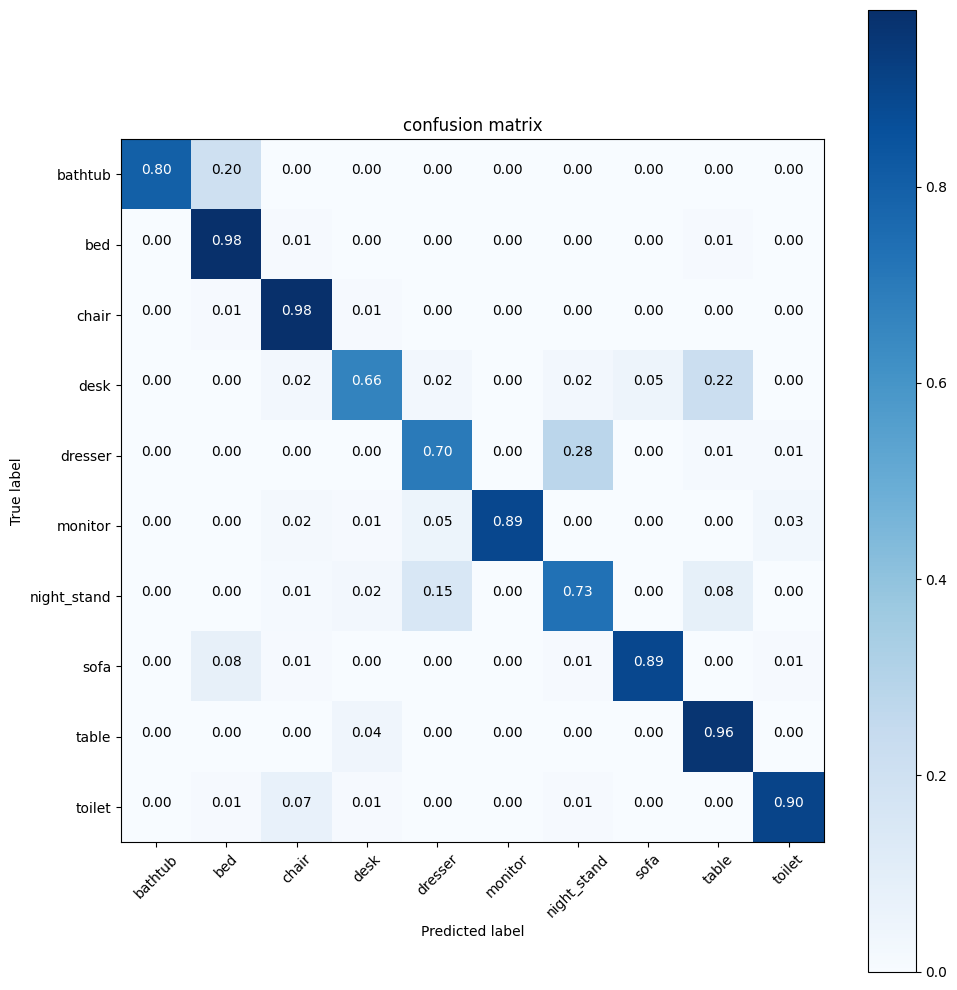

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


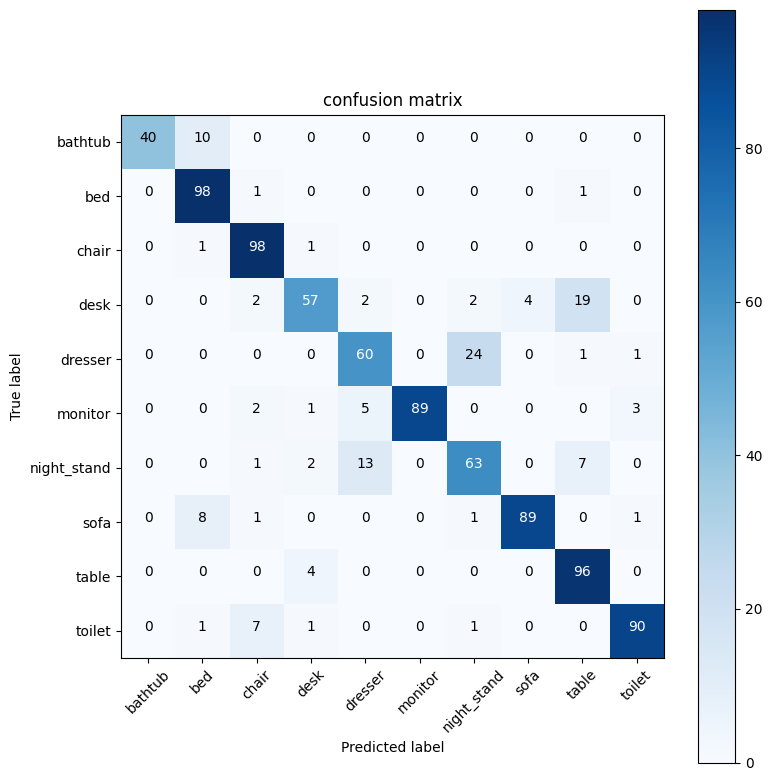

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)